In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Загрузка данных и обработка
Датасет был взят из предыдущей работы и обработка индентична.

In [4]:
TCGA_GBM_LGG_Mutations_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TCGA_GBM_LGG_Mutations_all.csv')

TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.drop(['Project', 'Case_ID', 'Primary_Diagnosis'], axis=1)
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Race != 'not reported']
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Race != '--']
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Age_at_diagnosis != '--']

columns = list(TCGA_GBM_LGG_Mutations_all.columns)
TCGA_InfoWithGrade = TCGA_GBM_LGG_Mutations_all.copy()

ind = []
for age in TCGA_GBM_LGG_Mutations_all.Age_at_diagnosis:
      l = age.split(' ')
      if len(l) > 2:
        years = float(l[0]) + round(float(l[2])/365, 2)
      else:
        years = float(l[0])
      ind.append(years)
TCGA_InfoWithGrade.loc[:, 'Age_at_diagnosis'] = ind
TCGA_InfoWithGrade.loc[:, 'Grade'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Grade'])[0]
TCGA_InfoWithGrade.loc[:, 'Gender'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Gender'])[0]
TCGA_InfoWithGrade.loc[:, 'Race'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Race'])[0]

columns.remove('Age_at_diagnosis')
columns.remove('Grade')
columns.remove('Gender')
columns.remove('Race')

for column in columns:
  TCGA_InfoWithGrade[column].loc[TCGA_InfoWithGrade[column] == 'NOT_MUTATED'] = 0
  TCGA_InfoWithGrade[column].loc[TCGA_InfoWithGrade[column] == 'MUTATED'] = 1

# Анализ

In [9]:
dtf_tr, dtf_t = model_selection.train_test_split(TCGA_InfoWithGrade, test_size=0.3)

train_x = dtf_tr.drop(['Grade'], axis=1)
train_y = dtf_tr['Grade']

test_x = dtf_t.drop(['Grade'], axis=1)
test_y = dtf_t['Grade']

In [10]:
# нормируем значения
Y = 'Grade'

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.
'''
 X_train - это весь экземпляр с атрибутами,
 y_train - это метка каждого экземпляра.
'''
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()# выводим

,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
306,1.0,0.276305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,1.0,0.024095,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,1.0,0.149558,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,0.0,0.167522,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327,0.0,0.564300,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index)
test_y_scaled = test_y

Text(0.5, 1.0, 'pearson correlation')

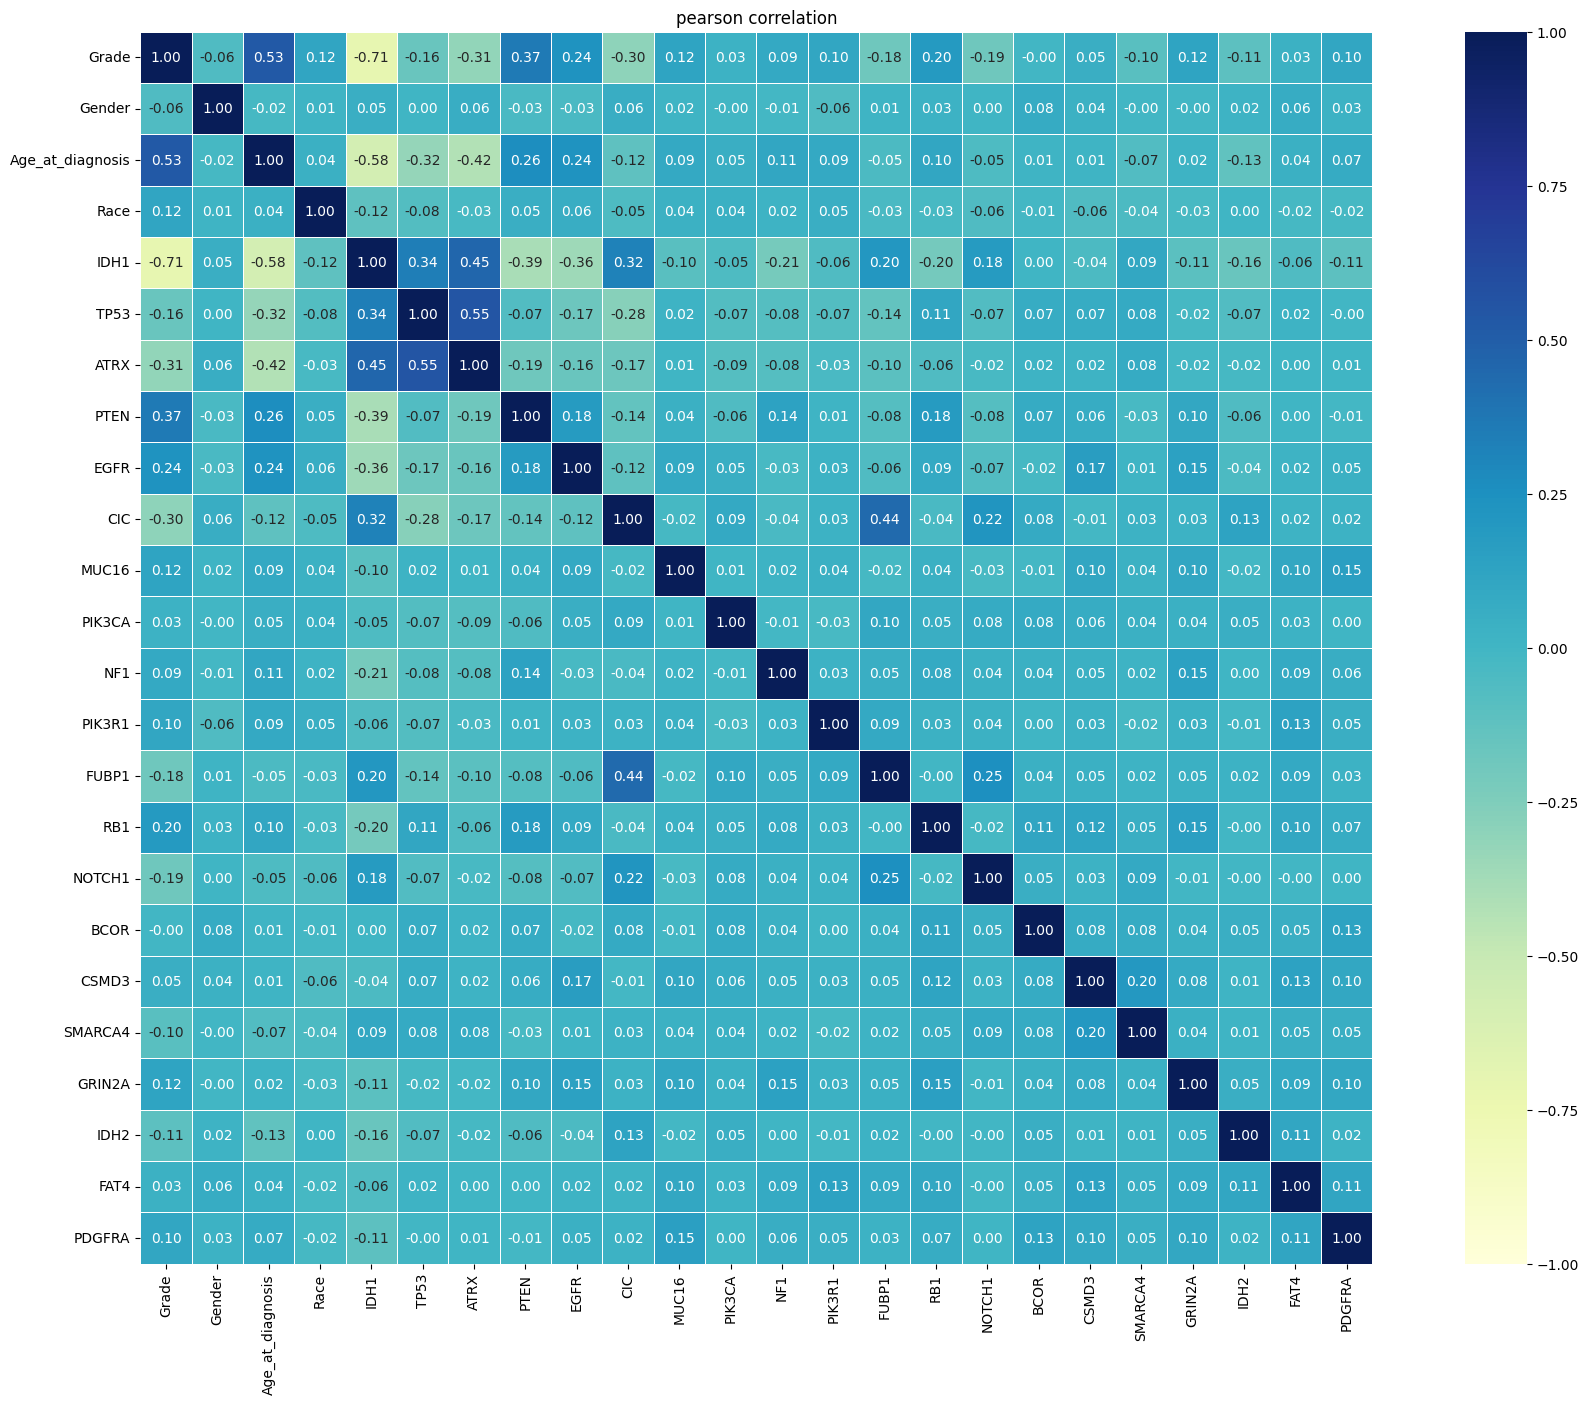

In [19]:
corr_matrix = (TCGA_InfoWithGrade).copy()
plt.figure(figsize=(24,16),dpi=100)

for col in corr_matrix.columns:
  if corr_matrix[col].dtype == "O":
        corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

In [21]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = train_x_scaled.values
y = train_y_scaled.values

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)

feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

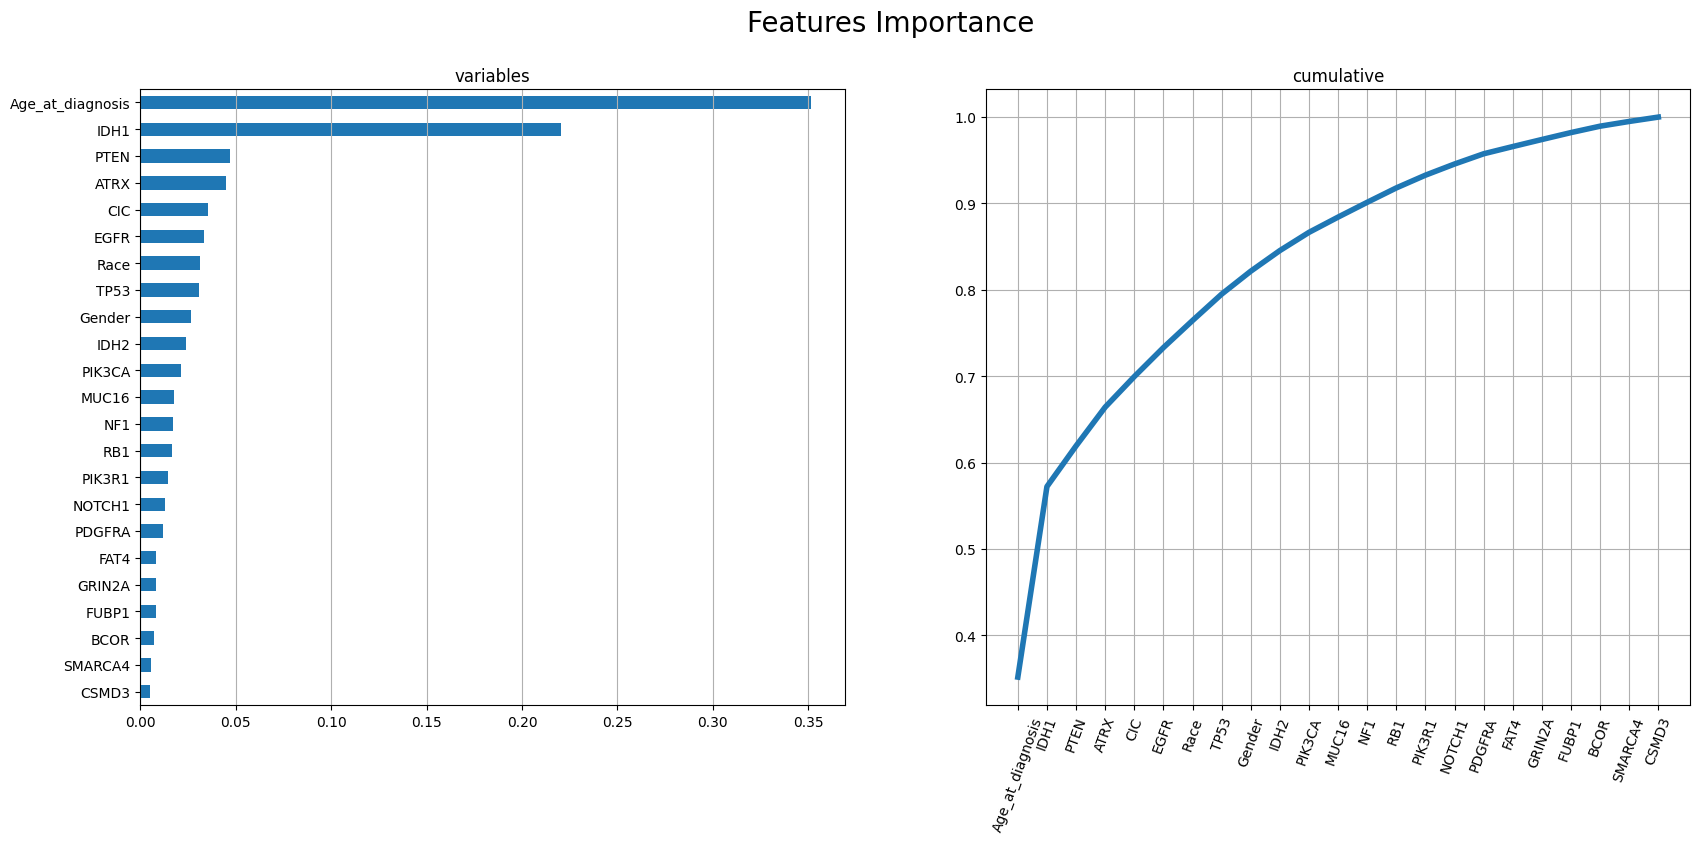

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(20,8),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

In [128]:
X_train = train_x_scaled.drop(['CSMD3','SMARCA4','BCOR'],axis=1)
y_train = train_y_scaled

X_test = test_x_scaled.drop(['CSMD3','SMARCA4','BCOR'],axis=1)
y_test = test_y_scaled

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()

y_train_tr = lab_enc.fit_transform(y_train)
y_test_tr = lab_enc.fit_transform(y_test)

In [129]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг. Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
 Оценивать качество предсказаний будем по RandomizedSearchCV
'''



## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[10,25,50,100,150,200],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5,7],    #максимальная глубина дерева
             'min_samples_split':[2,3,4,6,8],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,2,3,5,6],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4,5],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train_tr)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 4, 'learning_rate': 0.01}
Best Model mean accuracy: 0.8636100246269738


In [130]:
## train
## заполняем модель данным из трайн датасетов
model.fit(X_train, y_train_tr)
## test
predicted_prob = model.predict_proba(X_test) #прогнозирование
'''
Функция Predict() принимает только один аргумент , который представляет собой test датасет.
'''
predicted = model.predict(X_test).astype('int32')

In [131]:
recall = metrics.recall_score(y_test_tr, predicted, average="weighted")
precision = metrics.precision_score(y_test_tr, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test_tr, predicted, target_names=[str(i) for i in np.unique(y_test_tr)]))

Recall (all 1s predicted right): 0.89
Precision (confidence when predicting a 1): 0.89
Detail:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       139
           1       0.85      0.92      0.88       113

    accuracy                           0.89       252
   macro avg       0.89      0.89      0.89       252
weighted avg       0.89      0.89      0.89       252



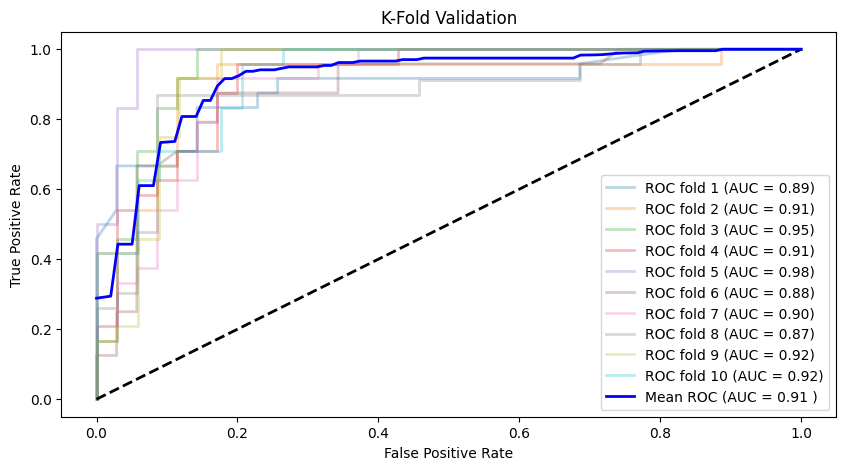

In [107]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train_tr):
    '''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу,
используя указанные значения индекса
X_train - это весь экземпляр с атрибутами,
y_train - это метка каждого экземпляра.
train_selected_test - Разделяет массивы / матрицы на случайные тестовые подмножества.

'''
    X_train_selected = X_train.iloc[train]

    y_train_selected = lab_enc.fit_transform(y_train.iloc[train])
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = lab_enc.fit_transform(y_train.iloc[test])

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
'''
Получим результат
'''
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
'''
построим график

'''
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

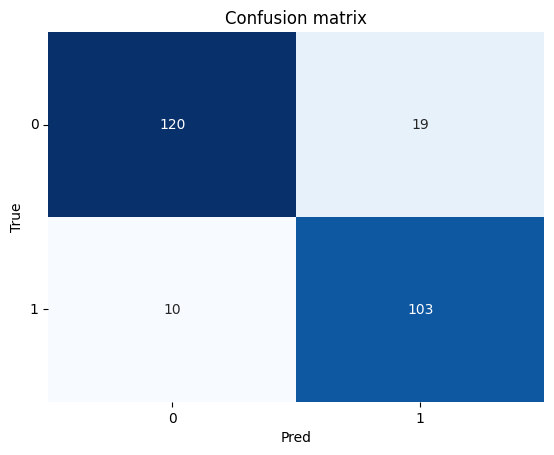

In [108]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test_tr, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()

In [96]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

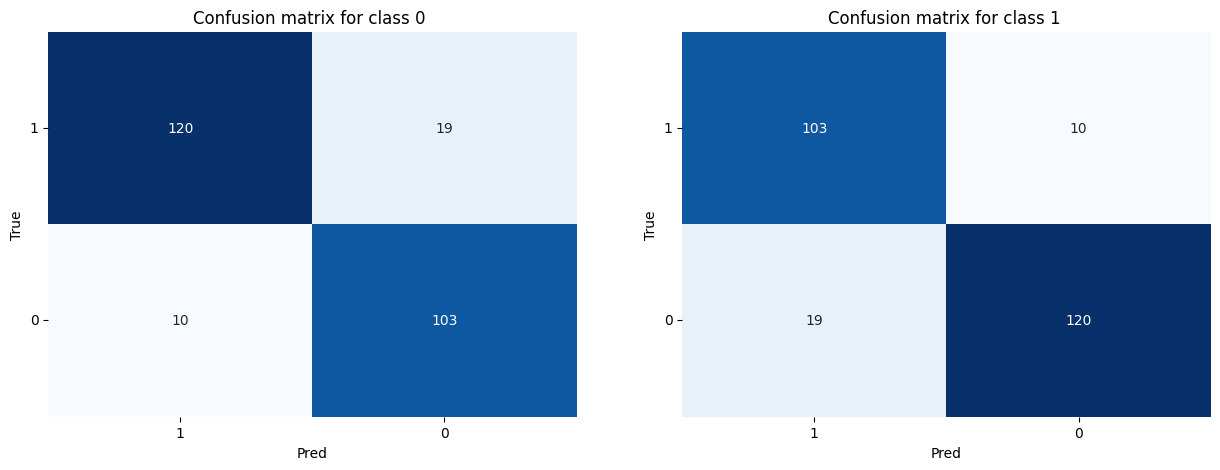

In [109]:
'''
Confusion matrix (для каждого класса по отдельности)
'''

classes = np.unique(y_test).astype(int)
lbs = [1,0]
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).
plt.grid - Настройка линий сетки.

'''
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5),dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

'''
построим график

'''
plt.show()

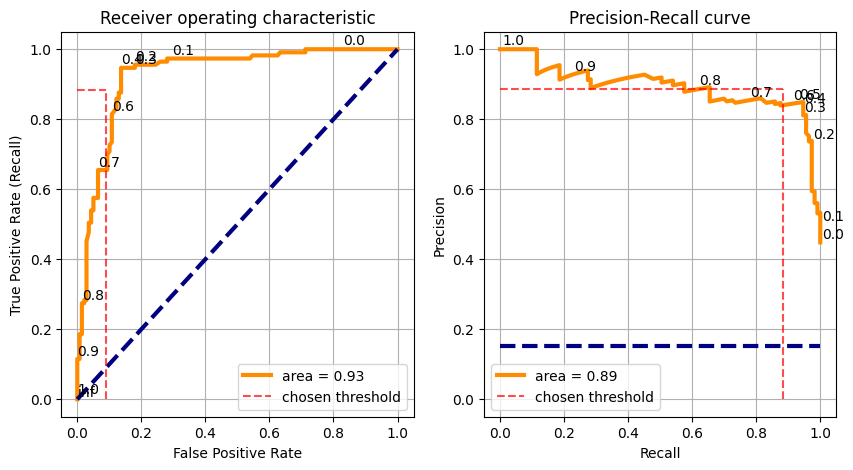

In [110]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test_tr, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим привую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_tr, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

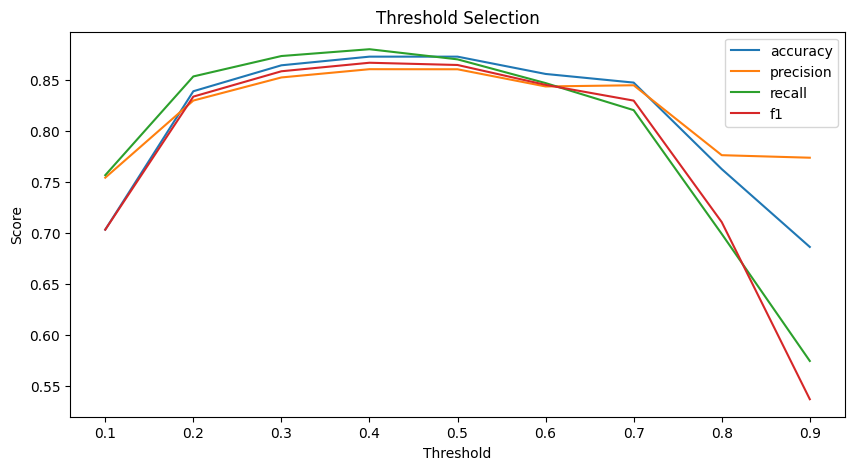

In [111]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train_tr, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)
'''
отрисовываем
'''

plt.show()